# [모듈 2.1] SK Learn Ridge, Lasso Regresson, XGBoost 모델 훈련 및 평가

이 노트북은 아래와 같은 작업을 합니다.
- 데이터 다운로드
- 피쳐를 이전 (세이지 메이커 내장 알고리즘 사용)과 같게 생성 합니다.
- 일부 피쳐에 대해서 로그 변환을 수행 합니다.
- 훈련과 테스트 데이터로 분리 합니다.
- Regulization 파라미터인 alpha 값을 서치하여 최적의 값을 구합니다.
- Ridge, Lasso, XGBoost 알고리즘을 훈련 합니다.
- Naive, Ridge, Lasso, XGBoost 모델을 평가 합니다.
- Lasso의 피쳐 중요도를 확인 합니다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import time
import json
import sagemaker.amazon.common as smac
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer

---
## Data

데이터를 다운로드 합니다. 자세한 데이타의 설명은 여기를 보세요. [here](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html).

In [2]:
# !wget http://robjhyndman.com/data/gasoline.csv

,thousands_barrels
0,6621.0
1,6433.0
2,6582.0
3,7224.0
4,6875.0


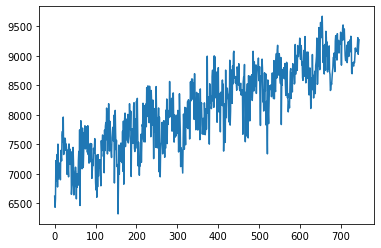

In [3]:
raw_gas = pd.read_csv('gasoline.csv', header=None, names=['thousands_barrels'])
display(raw_gas.head())
plt.plot(raw_gas)
plt.show()

데이터의 포인트:
- 시계열은 상승 트랜드를 가지고 있다.
- 년에 대한 계절성을 가지고 있다. 하지만 충분한 데이타의 높고 낮음의 변동성을 보여서 쉬운 문제는 아닙니다.
- 예상지 않은 급격한 하락 및 다소 pronounced seasonality(?) 가 있습니다.

위의 관찰을 바탕으로 아래와 같이 데이터를 변환 합니다.
- 우리의 타겟 변수는 thousands_barrels 입니다.
- 설명 변수를 아래와 같이 만듭니다.
    - thousands_barrels 에 대한 최근 4주 값
    - 트랜드. 위의 차트는 트랜드가 선형성을 보이지만, 우리는 로그 및 quadratic trends를 만들겁니다.
    - 플래그 변수인 (0 혹은 1) 은 계절성 및 주요한 휴일 주에 대해서 도움을 줄 수 있습니다.



## 피쳐 엔지니어링
다음과 같은 피쳐를 추가 합니다.
- 최신 4주의 값을 설명 피쳐를 만듦니다. (W-1, W-2, W-3, W-4)
- 트랜드 피쳐를 생성
- Week의 여부 피쳐를 생성 합니다.


In [4]:
def make_feature_engineering(gas):
    # 최근 4주의 값을 얻음
    gas['thousands_barrels_lag1'] = gas['thousands_barrels'].shift(1)
    gas['thousands_barrels_lag2'] = gas['thousands_barrels'].shift(2)
    gas['thousands_barrels_lag3'] = gas['thousands_barrels'].shift(3)
    gas['thousands_barrels_lag4'] = gas['thousands_barrels'].shift(4)
    # 트랜드 데이터를 얻음
    gas['trend'] = np.arange(len(gas))
    gas['log_trend'] = np.log1p(np.arange(len(gas)))
    gas['sq_trend'] = np.arange(len(gas)) ** 2
    # 52주 * 15의 값을 반복적으로 구한 후에 gas의 레코드 갯수 (745개) 만큼의 weeks 변수를 만듦
    weeks = pd.get_dummies(np.array(list(range(52)) * 15)[:len(gas)], prefix='week')
    gas = pd.concat([gas, weeks], axis=1)
    
    return gas

gas = make_feature_engineering(raw_gas)

In [5]:
print("gas :",gas.shape)
print(gas.columns)
gas

gas : (745, 60)
Index(['thousands_barrels', 'thousands_barrels_lag1', 'thousands_barrels_lag2',
       'thousands_barrels_lag3', 'thousands_barrels_lag4', 'trend',
       'log_trend', 'sq_trend', 'week_0', 'week_1', 'week_2', 'week_3',
       'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'week_9', 'week_10',
       'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16',
       'week_17', 'week_18', 'week_19', 'week_20', 'week_21', 'week_22',
       'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28',
       'week_29', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34',
       'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_40',
       'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46',
       'week_47', 'week_48', 'week_49', 'week_50', 'week_51'],
      dtype='object')


,thousands_barrels,thousands_barrels_lag1,thousands_barrels_lag2,thousands_barrels_lag3,thousands_barrels_lag4,trend,log_trend,sq_trend,week_0,week_1,...,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51
0,6621.0,NaN,NaN,NaN,NaN,0,0.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,6433.0,6621.0,NaN,NaN,NaN,1,0.693147,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,6582.0,6433.0,6621.0,NaN,NaN,2,1.098612,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7224.0,6582.0,6433.0,6621.0,NaN,3,1.386294,9,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6875.0,7224.0,6582.0,6433.0,6621.0,4,1.609438,16,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,9170.0,9089.0,9095.0,9075.0,9069.0,740,6.608001,547600,0,0,...,0,0,0,0,0,0,0,0,0,0
741,9306.0,9170.0,9089.0,9095.0,9075.0,741,6.609349,549081,0,0,...,0,0,0,0,0,0,0,0,0,0
742,9024.0,9306.0,9170.0,9089.0,9095.0,742,6.610696,550564,0,0,...,0,0,0,0,0,0,0,0,0,0
743,9175.0,9024.0,9306.0,9170.0,9089.0,743,6.612041,552049,0,0,...,0,0,0,0,0,0,0,0,0,0


## 데이터 전처리 

여기서는 로그 변환에 대한 전처리를 합니다.
타겟 변수인 thousands_barrels 를 대상으로 로그 변환을 해보고 어떻게 바뀌는지 확인 합니다.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7967109f28>,
      dtype=object)

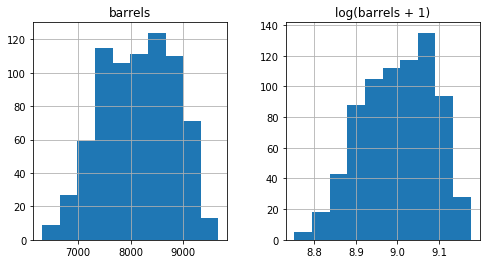

In [6]:
import matplotlib
from scipy.stats import skew

matplotlib.rcParams['figure.figsize'] = [8.0, 4.0]
barrels = pd.DataFrame({'barrels':gas['thousands_barrels'],
                        'log(barrels + 1)': np.log1p(gas['thousands_barrels'])
                       })
barrels.hist()

In [7]:
def log_transform(raw_df, all_apply=True):
    '''
    skewness 가 0.75 이상이면 로그 변환을 하여 정규분포를 따라갈 수 있게 변환 합니다.
    '''
    df = raw_df.copy()
    if all_apply:
        df = np.log1p(df)        
    else:
        numeric_feats = df.dtypes[df.dtypes != 'object'].index
        skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) # compute skewness
        skewed_feats = skewed_feats[skewed_feats > 0.75]
        skewed_feats = skewed_feats.index
        print(skewed_feats)
        df[skewed_feats] = np.log1p(df[skewed_feats])
    
    return df

def inverse_log_transform(df):
    df = np.expm1(df)
    return df

all_log_t = False
gas = log_transform(gas, all_log_t)

Index(['week_0', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6',
       'week_7', 'week_8', 'week_9', 'week_10', 'week_11', 'week_12',
       'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18',
       'week_19', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24',
       'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_30',
       'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36',
       'week_37', 'week_38', 'week_39', 'week_40', 'week_41', 'week_42',
       'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48',
       'week_49', 'week_50', 'week_51'],
      dtype='object')


In [8]:
gas

,thousands_barrels,thousands_barrels_lag1,thousands_barrels_lag2,thousands_barrels_lag3,thousands_barrels_lag4,trend,log_trend,sq_trend,week_0,week_1,...,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51
0,6621.0,NaN,NaN,NaN,NaN,0,0.000000,0,0.693359,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6433.0,6621.0,NaN,NaN,NaN,1,0.693147,1,0.000000,0.693359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6582.0,6433.0,6621.0,NaN,NaN,2,1.098612,4,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7224.0,6582.0,6433.0,6621.0,NaN,3,1.386294,9,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6875.0,7224.0,6582.0,6433.0,6621.0,4,1.609438,16,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,9170.0,9089.0,9095.0,9075.0,9069.0,740,6.608001,547600,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741,9306.0,9170.0,9089.0,9095.0,9075.0,741,6.609349,549081,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
742,9024.0,9306.0,9170.0,9089.0,9095.0,742,6.610696,550564,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
743,9175.0,9024.0,9306.0,9170.0,9089.0,743,6.612041,552049,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 훈련, 테스트 데이터 세트로 분리

데이터 분리:
- 최근 4주의 데이터를 설명 변수로 만들었기에, 최초 4개의 레코드는 삭제 합니다. (왜냐하면 4개의 설명 변수가 하나 이상은 NULL 이이서 입니다.)
- 타겟 변수를 설명 변수와 분리 합니다.
- 데이터를 8:2 비율로 훈련, 테스트 데이터로 분리 합니다.

In [9]:

# train_border=0.6
test_border=0.8 # 훈련과 테스트를 8:2 로 나누기위한 비율 입니다.
n_lags = 4 ; label = 'thousands_barrels'   
gas = gas.iloc[n_lags:, ]
# split_train = int(len(gas) * train_border)
split_test = int(len(gas) * test_border)

# train_y = gas[label][:split_train]
# train_X = gas.drop(label, axis=1).iloc[:split_train, ].to_numpy()
train_y = gas[label][:split_test]
train_X = gas.drop(label, axis=1).iloc[:split_test, ].to_numpy()

# validation_y = gas[label][split_train:split_test]
# validation_X = gas.drop(label, axis=1).iloc[split_train:split_test, ].to_numpy()
test_y = gas[label][split_test:]
test_X = gas.drop(label, axis=1).iloc[split_test:, ].to_numpy()


In [10]:
print(train_X.shape)
print(train_y.shape)


(592, 59)
(592,)


## 모델 훈련, 저장, 로딩

### Regulization Alpha 하이퍼 파리미터 서치
Alpha 리스트 값을 제공하여, 모델의 rmse (Root Mean Square Error)이 가장 작은 alpha 값을 찾습니다.

Ridge min_alpha:  1.5
Lasso min_alpha:  1.0


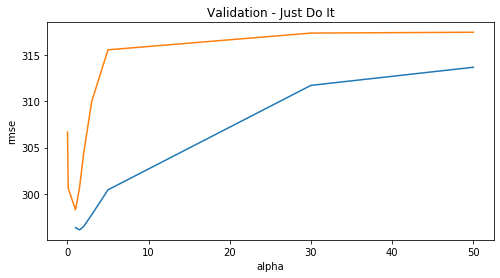

In [11]:
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb
from sklearn.model_selection import cross_val_score


def rmse_cv(model, X_train, y):
    '''
    5 cross-validaton을 하여 rmse 값을 리턴 합니다.
    '''
    rmse= np.sqrt(-cross_val_score(model, X_train, y,
                                   scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def search_alpha(alphas, train_X, train_y, model):
    '''
    주어진 alphas 리스트에서 rmse가 가장 작은 alphas값을 리턴 합니다.
    '''
    if model == 'ridge':
        cv = [rmse_cv(Ridge(alpha = alpha), train_X,train_y ).mean() 
                    for alpha in alphas]
    elif model == 'lasso':
        cv = [rmse_cv(Lasso(alpha = alpha), train_X,train_y ).mean() 
                    for alpha in alphas]        
    cv = pd.Series(cv, index = alphas)
    cv.plot(title = "Validation - Just Do It")
    plt.xlabel("alpha")
    plt.ylabel("rmse")

    min_alpha = cv[cv == cv.min()].index.values[0]

    
    return min_alpha

# Ridge
alphas = [1, 1.5, 2, 3, 5, 30, 50]
min_alpha = search_alpha(alphas, train_X, train_y,  model="ridge")
print("Ridge min_alpha: ", min_alpha)
# Lasso
alphas = [0.01, 0.1 , 1, 1.5, 2, 3, 5, 30, 50]
min_alpha = search_alpha(alphas, train_X, train_y,  model="lasso")
print("Lasso min_alpha: ", min_alpha)

### Ridge, Lasso, XGBoost 모델을 훈련 합니다.

In [12]:
import joblib
import os


def train(train_X, train_y, model, alpha=1.0):
    '''
    학습하고 모델을 리턴 합니다.
    '''
    if model =='ridge':
        model = Ridge(alpha= alpha, random_state=1000)
        print("Train Ridge model")
    elif model == 'lasso':
        model = Lasso(alpha=alpha, random_state=1000)
        print("Train Lasso model")      
    elif model =='xgboost':
        model = xgb.XGBRegressor(n_estimators=360, max_depth=5, learning_rate=0.1,random_state=1000 )
        print("Train Lasso model")      

        
    model.fit(train_X, train_y)        
    
    return model



def save_model(model, model_folder, model_name):
    '''
    모델을 지정된 경로에 저장 합니다.
    '''
    save_path = os.path.join(model_folder, model_name)
    joblib.dump(model, save_path)
    print(f'{save_path} is saved')
    
def model_fn(model_dir):
    """
    모델을 주어진 경로에서 로딩 합니다.
    """   
    pca = joblib.load(os.path.join(model_dir, "model.joblib"))
    
    return pca

def predict_fn(input_data, model):
    """
    주어진 입력 값에 대해서 모델을 통해서 예측을 합니다.
    """
    payload = input_data
    
    predictions = model.predict(payload)
    print("shape of predictions: ", predictions.shape)

    return predictions

def input_fn(input_data, request_content_type='text/csv'):
    """
    주어진 입력 데이터를 추론에 맞게 포맷을 변경 합니다.
    """
    n_feature = input_data.shape[1]
    sample = input_data.reshape(-1,n_feature)
    return sample

def evaluate(test_y, pred, metric = 'MdAPE'):
    '''
    MdAPE 값을 계산 합니다.
    '''
    if metric == 'MdAPE':
        MdAPE = np.median(np.abs(test_y - pred) / test_y)    
    return MdAPE


In [13]:
# Train
model_ridge = train(train_X, train_y, model = 'ridge', alpha = min_alpha)
model_lasso = train(train_X, train_y, model = 'lasso', alpha = min_alpha)
model_xgboost = train(train_X, train_y, model = 'xgboost') # , alpha = min_alpha)

# Save Model AS a test
model_folder = 'model'    
os.makedirs(model_folder, exist_ok=True)
model_name = 'model.joblib'
save_model(model_ridge, model_folder, model_name) # Ridge모델 저장

# input for evaluation
sample = input_fn(test_X)

# Load model
model_ridge = model_fn(model_folder)



Train Ridge model
Train Lasso model
Train Lasso model
model/model.joblib is saved


## 모델 평가

### Naive 모델 평가
기본 베이스 라인 (Naive 벤츠마크)를 아래와 같이 정의 하겠습니다.
- **Naive Benchmark = 해당 주의 1년 전의 값의 제곱 / 해당 주의 2년 전의 값**



In [14]:
def compute_naive_pred(gas, split_test):
    gas_eval = gas.copy()
    gas_eval['thousands_barrels_lag52'] = gas['thousands_barrels'].shift(52)
    gas_eval['thousands_barrels_lag104'] = gas['thousands_barrels'].shift(104)
    gas_eval['thousands_barrels_naive_forecast'] = gas_eval['thousands_barrels_lag52'] ** 2 / gas_eval['thousands_barrels_lag104']
    naive = gas_eval[split_test:]['thousands_barrels_naive_forecast'].to_numpy()
    
    return naive

naive = compute_naive_pred(gas, split_test)

Naive-onestep-ahead MdAPE =  0.03687277085962615


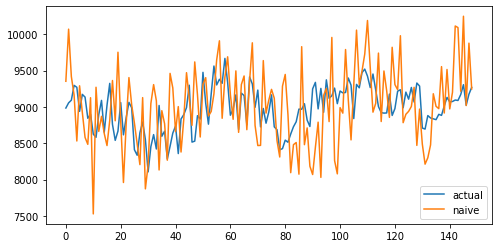

In [15]:

def show_chart(test_y, pred):
    plt.plot(np.array(test_y), label='actual')
    plt.plot(pred, label='naive')
    plt.legend()
    plt.show()

MdAPE = evaluate(test_y, naive)
print('Naive-onestep-ahead MdAPE = ', MdAPE)    
show_chart(test_y, naive) 

### 리지 모델 평가

In [16]:
# Predict
ridge_pred = predict_fn(sample, model_ridge)


shape of predictions:  (149,)


Ridge-onestep-ahead MdAPE =  0.016805961119412825


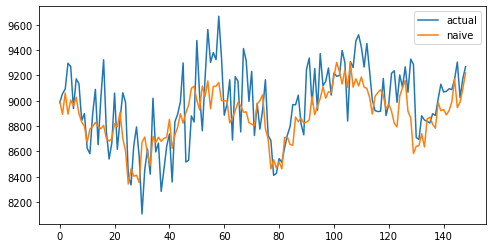

In [17]:
# Evaluate
MdAPE = evaluate(test_y, ridge_pred)
print('Ridge-onestep-ahead MdAPE = ', MdAPE)

show_chart(test_y, ridge_pred) 

## Lasso 모델 평가

shape of predictions:  (149,)
Lasso-onestep-ahead MdAPE =  0.01650186494051367


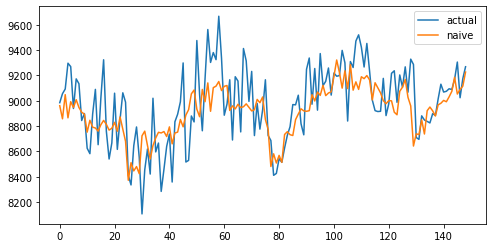

In [18]:
# Predict
lasso_pred = predict_fn(sample, model_lasso)

# Evaluate
MdAPE = evaluate(test_y, lasso_pred)
print('Lasso-onestep-ahead MdAPE = ', MdAPE)

show_chart(test_y, lasso_pred) 


## XGBoost 모델 평가

shape of predictions:  (149,)
xgboost_pred-onestep-ahead MdAPE =  0.02355323269872151


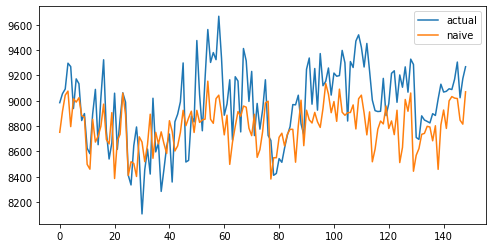

In [19]:
# Predict
xgboost_pred = predict_fn(sample, model_xgboost)

# Evaluate
MdAPE = evaluate(test_y, xgboost_pred)
print('xgboost_pred-onestep-ahead MdAPE = ', MdAPE)

show_chart(test_y, xgboost_pred) 



## Lasso Feature importance

아래는 한번 실행의 예시지만 최신 과거 4주의 값에 대해서의 가중치 입니다. 이들은 입력값이 크기에 이에 따라 작은 가중치가 할당됨을 추측할 수 있습니다.
```
thousands_barrels_lag1      0.010251
thousands_barrels_lag2      0.104384
thousands_barrels_lag3      0.178383
thousands_barrels_lag4      0.125864
trend                       2.105096
log_trend                 -30.493467
sq_trend                   -0.000596
week_0                   -337.606021
week_1                   -345.055979
week_2                     -0.000000
week_3                     -0.000000
```

In [20]:
gas_X = gas.drop(columns=['thousands_barrels'])

In [21]:
# coef = pd.Series(model_lasso.coef_, index = gas.columns)
coef = pd.Series(model_lasso.coef_, index = gas_X.columns)
coef

thousands_barrels_lag1      0.010251
thousands_barrels_lag2      0.104384
thousands_barrels_lag3      0.178383
thousands_barrels_lag4      0.125864
trend                       2.105096
log_trend                 -30.493467
sq_trend                   -0.000596
week_0                   -337.606021
week_1                   -345.055979
week_2                     -0.000000
week_3                     -0.000000
week_4                    -68.605559
week_5                   -119.339748
week_6                      0.000000
week_7                     -0.000000
week_8                     -0.000000
week_9                    -64.640345
week_10                   -55.062759
week_11                    -0.000000
week_12                   164.865114
week_13                   -34.326427
week_14                    -0.000000
week_15                     0.000000
week_16                   149.215577
week_17                     0.000000
week_18                    10.726191
week_19                     0.000000
w

coef 가 0인 것은 자연스럽게 삭제가 됩니다. 피쳐가 줄어드는 효과가 발생 합니다.

In [22]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 40 variables and eliminated the other 19 variables


In [23]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

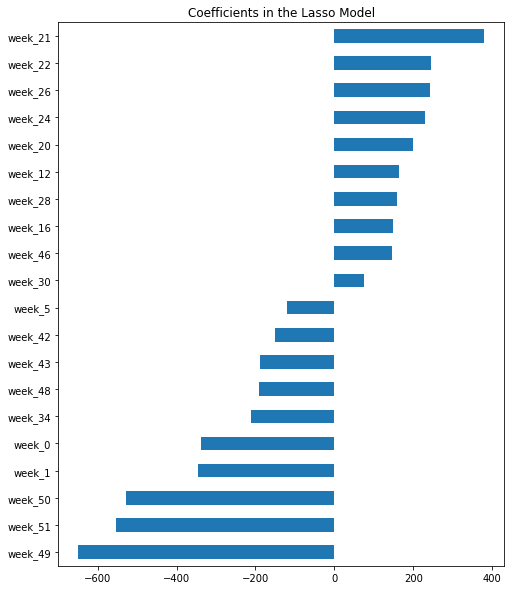

In [24]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")